## Variable Selection

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# select item (use item 2 if it switched model numbers but is same item)
item = '4114'
#item2 = '5397'
item2 = None

# month to start the forecast
month = datetime.today().month

period = 'M'

# percentage increase in store count
store_count_change = 1
growth_rate = 1 + (store_count_change / 100) # converts to a percentage

# this changes the length dropped off for the benchmarks
forecast_length = 4

# this changes the array in the pycaret if you do the arange it will do a point forecast at the future time
#forecast_lenth_array = np.arange(forecast_length, forecast_length+1)
forecast_lenth_array = forecast_length
print("Growth Rate:", growth_rate)

Growth Rate: 1.01


## Data

In [23]:
df = pd.read_csv('Items Shipped by Item by Month.csv')

In [24]:
df.head()

,Date,Item,Item Description,Product Group,Parent Product Group,Quantity,Amount
0,2024-Oct,2379,Tabletop Pizza Oven-Walmart 2024,Pizza Oven,Cooking Unit,702.0,61180.28
1,2024-Oct,2339,17 in Black Adventure Ready with Hard Cover,Griddles,Cooking Unit,1069.0,60940.06
2,2024-Oct,2341,Adventure Ready Omnivore 22in Griddle w/ Hood ...,Griddles,Cooking Unit,1252.0,106745.52
3,2024-Oct,2304,Adventure Ready 22in Tabletop Griddle W/ Hard ...,Griddles,Cooking Unit,495.0,31424.78
4,2024-Oct,2177,"36"" GRIDDLE UPGRADE - Omni Griddle Plate",Griddles,Cooking Unit,1000.0,152213.60


## Data Formatting

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34808 entries, 0 to 34807
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  34808 non-null  object 
 1   Item                  34808 non-null  object 
 2   Item Description      34657 non-null  object 
 3   Product Group         34549 non-null  object 
 4   Parent Product Group  34808 non-null  object 
 5   Quantity              34792 non-null  float64
 6   Amount                34808 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.9+ MB


In [26]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%b') # this is for the month


if item2:
    df_item = df[(df['Item'] == item) | (df['Item'] == item2)]
else:
    df_item = df[df['Item'] == item]

df_item = df_item.groupby(['Date'])['Quantity'].sum().reset_index().sort_values(by=['Date'], ascending=True)

df_item = df_item.resample(period, on='Date').sum().reset_index()

last_month = datetime.strptime(df_item['Date'].astype(str).iloc[-1], '%Y-%m-%d')
month_number = last_month.month
month_number

if month_number < month:
    df_item = df_item
else:
    df_item = df_item[:-1] # drop the last month if in start or middle of month

df_item.tail(15)

,Date,Quantity
42,2023-07-31,97788.0
43,2023-08-31,86688.0
44,2023-09-30,69396.0
45,2023-10-31,16128.0
46,2023-11-30,30240.0
47,2023-12-31,89556.0
48,2024-01-31,43560.0
49,2024-02-29,68544.0
50,2024-03-31,92736.0
51,2024-04-30,139392.0


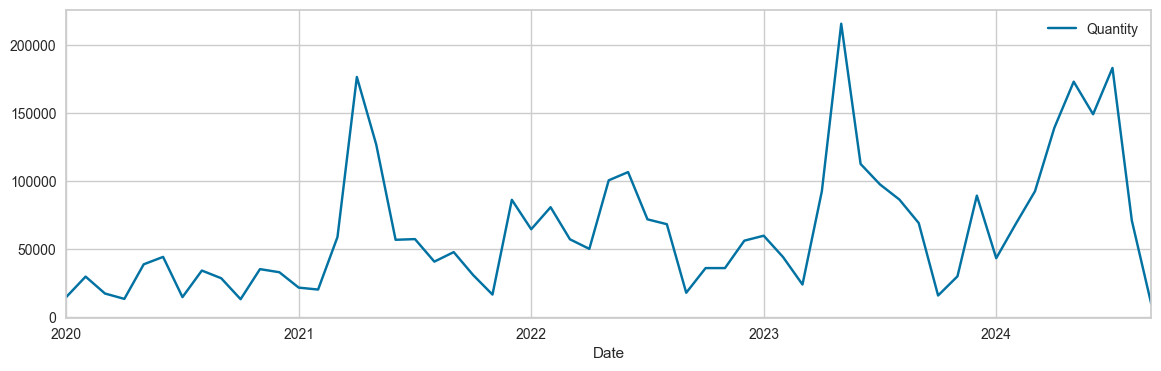

In [27]:
# Plot the time series data
df_item.plot(x='Date', y='Quantity', figsize=(14,4))
unchanged_df = df_item.copy() # saving a copy of the data set to then plot forecasts with original data

In [28]:
# adding constant for box cox transformation
df_item['Quantity'] = df_item['Quantity'] + 1

## Pycaret Forecast

#### Setting up experiment

In [29]:
from pycaret.time_series import *

In [30]:
exp = TSForecastingExperiment()
exp.setup(data=df_item,
          index='Date',
          target='Quantity',
          transform_target='box-cox',
          fh=forecast_lenth_array,
          seasonal_period=12)

,Description,Value
0,session_id,6406
1,Target,Quantity
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(57, 1)"
5,Transformed data shape,"(57, 1)"
6,Transformed train set shape,"(53, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### Checking Set Up

In [31]:
exp.plot_model(plot='train_test_split')

In [32]:
#### Check cross-validation setup  ----
exp.plot_model(plot="cv")

In [33]:
exp.plot_model(plot='acf')
exp.plot_model(plot='pacf')

### Comparing Models

In [34]:
best = exp.compare_models(sort='rmse', turbo=False)
comparison_results = exp.pull()
best_model_name = comparison_results.iloc[0]['Model']
mean_rmse_compare = comparison_results.iloc[0]['RMSE']

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.1140,0.8525,30699.4535,34313.9629,0.6666,0.4387,-0.7509,0.0667
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.1807,0.9847,32760.8292,39866.3903,0.7687,0.4243,-1.0466,0.0600
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.1967,0.9912,33237.9138,40156.9107,0.7722,0.4301,-1.0606,0.3133
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.1967,0.9912,33237.9138,40156.9107,0.7722,0.4301,-1.0606,0.0533
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.2210,1.0006,33856.2027,40520.2501,0.7833,0.4340,-1.1083,0.1267
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.2500,1.0157,34629.3652,41105.4973,0.7863,0.4430,-1.1584,0.1533
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.2874,1.0249,35866.3144,41428.8617,0.6259,0.4962,-1.0812,0.1233
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.2529,1.0443,35059.3388,42403.7178,0.5757,0.4583,-1.0295,0.1167
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.3491,1.0874,37467.2386,43974.3816,0.7160,0.4913,-1.3097,0.1167
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.3425,1.0919,37075.0113,44090.9000,0.8472,0.4663,-1.5969,0.1600


#### Tune Model

In [35]:
try:
    # Tune the model
    tuned = exp.tune_model(best, optimize='RMSE', n_iter=100, choose_better=True)
    # Retrieve the tuning results
    tuned_results = exp.pull()
    # Extract the mean RMSE from the results
    mean_rmse = tuned_results.loc['Mean', 'RMSE']
except ValueError:
    mean_rmse = mean_rmse_compare
    print("Could Not Tune")


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-05,0.6567,0.5504,17298.6347,21410.8651,0.2063,0.1840,-0.8230
1,2023-09,0.8202,0.6342,22370.5820,25619.7686,0.7931,0.5141,0.1360
2,2024-01,1.1536,1.0510,32994.0670,43033.9720,0.2686,0.2943,-0.1225
Mean,NaT,0.8768,0.7452,24221.0945,30021.5352,0.4227,0.3308,-0.2698
SD,NaT,0.2068,0.2189,6539.8750,9360.2475,0.2631,0.1372,0.4051


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.9s finished


#### Finalizing Model

In [36]:
try:
    final = exp.finalize_model(tuned)
except NameError:
    final = exp.finalize_model(best)

In [37]:
exp.plot_model(final, plot='forecast', data_kwargs={'fh':12})

In [38]:
unseen_predictions = exp.predict_model(final)
#unseen_predictions = exp.predict_model(final, fh=forecast_lenth_array, X=prediction_df)
unseen_predictions

,y_pred
2024-10,28244.7113
2024-11,76637.9031
2024-12,42635.8642
2025-01,22134.3897


In [39]:
unseen_predictions['y_pred'] = unseen_predictions['y_pred'] * growth_rate

In [40]:
# making it so we can plot the forecast
unchanged_df.index = unchanged_df['Date']
unchanged_df = unchanged_df.drop(columns = ['Date'])

In [41]:
# Ensure the index is a DatetimeIndex before converting it to PeriodIndex
if isinstance(unseen_predictions.index, pd.PeriodIndex):
    unseen_predictions.index = unseen_predictions.index.to_timestamp()

# Convert the index to show only "YYYY-MM"
unseen_predictions.index = unseen_predictions.index.to_period(period).strftime('%Y-%m')

# Rename the Series
unseen_predictions.name = 'Predicted Values'

## Visualizing Forecasts

Best Tuned model: Gradient Boosting w/ Cond. Deseasonalize & Detrending with RMSE 30021.54
               y_pred
2024-10  28527.158413
2024-11  77404.282131
2024-12  43062.222842
2025-01  22355.733597


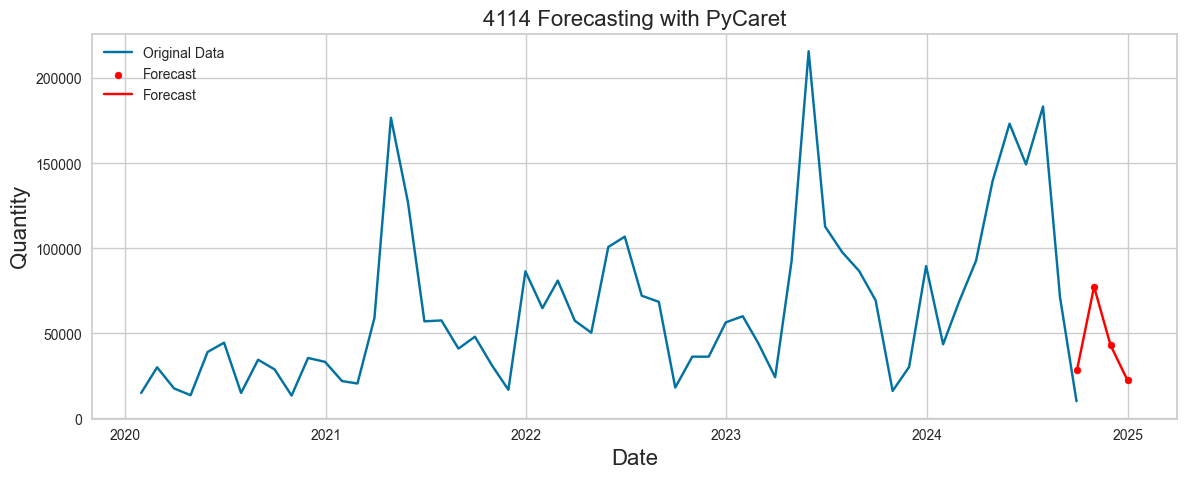

In [42]:
# Print RMSE and model information
try:
    print(f"Best Tuned model: {best_model_name} with RMSE {mean_rmse:.2f}")
except NameError:
    print(f"Best Untuned model: {best_model_name} with Mean RMSE: {mean_rmse_compare:.2f}")

print(unseen_predictions)

# Plotting forecast with original data
plt.figure(figsize=(14, 5))
plt.plot(unchanged_df.index, unchanged_df['Quantity'], label='Original Data')
plt.scatter(pd.to_datetime(unseen_predictions.index), unseen_predictions, color='red', label='Forecast', s=25)
plt.plot(pd.to_datetime(unseen_predictions.index), unseen_predictions, color='red', label='Forecast')
plt.title(f'{item} Forecasting with PyCaret', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.legend(loc='upper left')
plt.show()